# Finite-Difference Playground: Using NRPy-Generated C Codes in a Larger Project

## Author: Zach Etienne

## This notebook demonstrates the use of NRPy-generated C codes in finite-difference derivatives computation and verifies fourth-order convergence. It invites further exploration of higher-order accuracies and highlights the advantages of NRPy’s handling of complex higher-dimensional expressions.

## Introduction:
To illustrate how NRPy-based codes can be used, we write a C code that makes use of an NRPy-generated C kernel. This is a rather simple example, as the C code generated by NRPy could be written by hand. However, as we will see in later modules, NRPy’s true strengths lie in its automatic handling of far more complex and generic expressions, in higher dimensions. For the time being, bear with NRPy; its true powers will become clear soon!

# Table of Contents

This notebook is organized as follows:

1. [Step 1](#Step-1:-Register-the-C-function-finite_diff_tutorial__second_deriv()): Register the C function `finite_diff_tutorial__second_deriv()`
1. [Step 2](#Step-2:-Finite-Difference-Playground:-A-Complete-C-Code-for-Analyzing-Finite-Difference-Expressions-Output-by-NRPy): Finite-Difference Playground: A Complete C Code for Analyzing Finite-Difference Expressions Output by NRPy
1. [Step 3](#Step-3:-Exercises): Exercises

# Step 1: Register the C function `finite_diff_tutorial__second_deriv()`
### [Back to [top](#Table-of-Contents)]

We start by setting up a simple 1D gridfunction environment and then construct a C kernel that evaluates a second derivative using a fourth-order-accurate finite-difference stencil.

The kernel will operate on a small stencil of values of a gridfunction `phi` stored in a 1D array, and will produce the second derivative stored in a separate gridfunction `output`. Both gridfunctions are packed into a single array using a simple 2D-to-1D index mapping macro.

In [2]:
# Step 1: Import needed NRPy core modules
import os
import shutil
import subprocess

import sympy as sp

import nrpy.params as par          # NRPy: parameter interface
import nrpy.c_codegen as ccg       # NRPy: core C code output module (imported for completeness)
import nrpy.c_function as cfc      # NRPy: C function representation and registry
import nrpy.finite_difference as fin  # NRPy: finite difference helper functions
import nrpy.grid as gri            # NRPy: gridfunction registration tools
import nrpy.indexedexp as ixp      # NRPy: indexed expressions (e.g., tensors, vectors, etc.)

# Set basic NRPy infrastructure parameters
par.set_parval_from_str("Infrastructure", "BHaH")

# Ensure a clean registry of gridfunctions
gri.glb_gridfcs_dict.clear()

# Register the input gridfunction "phi" and the gridfunction to which data are output, "output"
phi, output = gri.register_gridfunctions(["phi", "output"], group="AUX")

# Declare phi_dDD as a rank-2 indexed expression: phi_dDD[i][j] = partial_i partial_j phi
phi_dDD = ixp.declarerank2("phi_dDD", dimension=1, symmetry="nosym")

# Set output to partial_0^2 phi (symbolic expression; not used directly in the C kernel below,
# but included to mirror the tensor notation)
output_expr = phi_dDD[0][0]

Now we set up the C code output directory that will store all generated C codes.

In [3]:
# Step 1.a: Create C code output directory
Ccodesrootdir = os.path.join("FiniteDifferencePlayground_Ccodes")
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
os.makedirs(Ccodesrootdir, exist_ok=True)

Next we declare C macros that will appear within `NRPy_basic_defines.h`, which is `#include`d in the C code below. Here we define a simple 2D-to-1D index mapping and gridfunction indices for the input and output fields.

In [4]:
nrpy_basic_defines_str = r"""
// Basic macros for the finite-difference playground example.

// Declare the IDX2S(gf,i) macro, which enables us to store 2-dimensions of
//   data in a 1D array. In this case, consecutive values of "i"
//   ("gf" held to a fixed value) are consecutive in memory, where
//   consecutive values of "gf" (fixing "i") are separated by N elements in
//   memory.
#define IDX2S(gf, i) ( (i) + Npts_in_stencil * (gf) )

// Declare PHIGF and OUTPUTGF, used for IDX2S's gf input.
#define PHIGF    0
#define OUTPUTGF 1
"""

with open(os.path.join(Ccodesrootdir, "NRPy_basic_defines.h"), "w") as f:
    f.write(nrpy_basic_defines_str)

Next, we register the C function `finite_diff_tutorial__second_deriv()`, which contains the core C-code kernel for evaluating the finite-difference second derivative.

Registering C functions with NRPy in this way encourages developers to:

* Store function metadata (description, includes, parameters, etc.) alongside the body.
* Generate function prototypes and bodies in a consistent style.
* Reuse the same registration and output infrastructure across many projects.

In this example, we obtain the finite-difference coefficients from
`finite_difference.compute_fdcoeffs_fdstencl()` and explicitly assemble the C kernel for the second derivative with respect to `x^0`.

In [5]:
def register_CFunction_finite_diff_tutorial__second_deriv():
    """
    Register the core finite-difference kernel C function
    finite_diff_tutorial__second_deriv() with NRPy's CFunction registry.
    """
    includes = ["NRPy_basic_defines.h"]
    desc = r"""Evaluate phi''(x0), the second derivative of phi, a function sampled on a uniform grid.

The derivative is evaluated using a standard 4th-order-accurate finite-difference stencil.

See Tutorial-Finite_Difference_Derivatives.ipynb in
https://github.com/zachetienne/nrpytutorial for more details.
"""
    cfunc_type = "void"
    name = "finite_diff_tutorial__second_deriv"
    params = "const double *in_gfs, const double invdx0, const int i0, const int Npts_in_stencil, double *aux_gfs"

    # Use the finite_difference helper to construct the 4th-order, centered second-derivative stencil.
    # We want partial_0^2, which corresponds to the derivative operator string "dDD00".
    fd_order = 4  # 4th-order-accurate derivative
    fdcoeffs, fdstencl = fin.compute_fdcoeffs_fdstencl("dDD00", fd_order)

    body_lines = []
    body_lines.append("  const double invdx0_sq = invdx0*invdx0;")
    body_lines.append("  double FD_result = 0.0;")

    for coeff, stencil in zip(fdcoeffs, fdstencl):
        i0_offset = stencil[0]
        if i0_offset == 0:
            idx_str = "i0"
        elif i0_offset > 0:
            idx_str = f"i0+{i0_offset}"
        else:
            # i0_offset < 0
            idx_str = f"i0{i0_offset}"  # e.g., i0-2

        coeff_c = sp.ccode(coeff)  # Convert SymPy Rational to valid C floating-point expression
        body_lines.append(
            f"  FD_result += ({coeff_c})*in_gfs[IDX2S(PHIGF, {idx_str})];"
        )

    body_lines.append("  aux_gfs[IDX2S(OUTPUTGF, i0)] = invdx0_sq*FD_result;")

    body = "\n".join(body_lines) + "\n"

    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body,
    )

Let us take a look at NRPy’s generated version of this function. All we need to do is call `register_CFunction_finite_diff_tutorial__second_deriv()` to register the function, and then it can be accessed directly from `c_function.CFunction_dict`.

In [6]:
register_CFunction_finite_diff_tutorial__second_deriv()
print(cfc.CFunction_dict["finite_diff_tutorial__second_deriv"].full_function)

#include "NRPy_basic_defines.h"

/**
 * Evaluate phi''(x0), the second derivative of phi, a function sampled on a uniform grid.
 *
 * The derivative is evaluated using a standard 4th-order-accurate finite-difference stencil.
 *
 * See Tutorial-Finite_Difference_Derivatives.ipynb in
 * https://github.com/zachetienne/nrpytutorial for more details.
 */
void finite_diff_tutorial__second_deriv(const double *in_gfs, const double invdx0, const int i0, const int Npts_in_stencil, double *aux_gfs) {
  const double invdx0_sq = invdx0 * invdx0;
  double FD_result = 0.0;
  FD_result += (-1.0 / 12.0) * in_gfs[IDX2S(PHIGF, i0 - 2)];
  FD_result += (4.0 / 3.0) * in_gfs[IDX2S(PHIGF, i0 - 1)];
  FD_result += (-5.0 / 2.0) * in_gfs[IDX2S(PHIGF, i0)];
  FD_result += (4.0 / 3.0) * in_gfs[IDX2S(PHIGF, i0 + 1)];
  FD_result += (-1.0 / 12.0) * in_gfs[IDX2S(PHIGF, i0 + 2)];
  aux_gfs[IDX2S(OUTPUTGF, i0)] = invdx0_sq * FD_result;
} // END FUNCTION finite_diff_tutorial__second_deriv



# Step 2: Finite-Difference Playground: A Complete C Code for Analyzing Finite-Difference Expressions Output by NRPy
### [Back to [top](#Table-of-Contents)]

NRPy is designed to generate C code kernels at the heart of more advanced projects. As an example of its utility, let us now write a simple C code that calls the function `finite_diff_tutorial__second_deriv()` to evaluate the finite-difference second derivative of

$$f(x) = \sin(x)$$

at fourth-order accuracy. Let us call the finite-difference second derivative of $f$ evaluated at a point $x$ $f''(x)_{\rm FD}$. A fourth-order-accurate $f''(x)_{\rm FD}$ will, in the truncation-error-dominated regime, satisfy

$$f''(x)_{\rm FD} = f''(x)_{\rm exact} + \mathcal{O}(\Delta x^4).$$

Therefore, the [relative error](https://en.wikipedia.org/wiki/Approximation_error) between the finite-difference derivative and the exact value should be given, to good approximation, by

$$E_{\rm Rel} = \left| \frac{f''(x)_{\rm FD} - f''(x)_{\rm exact}}{f''(x)_{\rm exact}} \right| \propto \Delta x^4,$$

so that (taking the base-10 logarithm of both sides of the equation)

$$\log_{10} E_{\rm Rel} = 4 \log_{10}(\Delta x) + \log_{10}(k),$$

where $k$ is the proportionality constant, divided by $f''(x)_{\rm exact}$.

Let us confirm this scaling using our finite-difference playground code, which calls the NRPy-generated C function `finite_diff_tutorial__second_deriv()` to evaluate $f''(x)_{\rm FD}$ at fourth-order accuracy, and outputs $\log_{10}(\Delta x)$ and $\log_{10} E_{\rm Rel}$ over a range of $\Delta x$ values that are dominated by truncation error.

In [7]:
def register_CFunction_main__finite_difference_playground():
    includes = ["<stdio.h>", "<stdlib.h>", "<math.h>", "NRPy_basic_defines.h"]
    prefunc  = r"""
// Define the function we wish to differentiate, as well as its exact second derivative:
double f(const double x)           { return  sin(x); } // f(x)
double f_dDD_exact(const double x) { return -sin(x); } // f''(x)

// Define the uniform grid coordinate:
//   x_i = (x_0 + i*Delta_x)
double x_i(const double x_0,const int i,const double Delta_x) {
  return (x_0 + (double)i*Delta_x);
}
"""
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Write test data to gridfunctions
// Step 2: Overwrite all data in ghost zones with NaNs
// Step 3: Apply curvilinear boundary conditions
// Step 4: Print gridfunction data after curvilinear boundary conditions have been applied
// Step 5: Free all allocated memory
"""
    cfunc_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body  = r"""  // Step 0: Read command-line arguments (not used in this example)

  // Step 1: Set some needed constants
  const int Npts_in_stencil = 5; // Number of points in the 4th-order stencil (fd_order + 1)
  const double PI = 3.14159265358979323846264338327950288; // The scale over which the sine function varies.
  const double x_eval = PI/4.0; // x_0 = desired x at which we wish to compute f(x)

  // Step 2: Evaluate f''(x_eval) using the exact expression:
  double EX = f_dDD_exact(x_eval);

  // Step 3: Allocate space for gridfunction input and output.
  double *restrict gfs  = (double *restrict)malloc(sizeof(double)*Npts_in_stencil*2);

  // Step 4: Loop over grid spacings
  for(double Delta_x = 1e-3*(2*PI);Delta_x<=1.5e-1*(2*PI);Delta_x*=1.1) {

    // Step 4a: x_eval is the center point of the finite differencing stencil,
    //          thus x_0 = x_eval - 2*Delta_x for a 4th-order-accurate second derivative stencil.
    //          In general, for the integer Npts_in_stencil, we have
    //          x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x,
    //          where we rely upon integer arithmetic (which always rounds down) to ensure
    //          Npts_in_stencil/2 = 5/2 = 2 for 4th-order-accurate first and second finite difference derivatives.
    const double x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x;

    // Step 4b: Set phi = PHIGF to be f(x) as defined in the
    //          f(const double x) function above, where x_i = x_0 + i*Delta_x:
    for(int ii=0;ii<Npts_in_stencil;ii++) {
      gfs[IDX2S(PHIGF, ii)] = f(x_i(x_0, ii, Delta_x));
    }

    // Step 4c: Set invdx0, which is needed by the NRPy-generated finite_diff_tutorial__second_deriv() function
    const double invdx0 = 1.0/Delta_x;

    // Step 4d: Evaluate the finite-difference second derivative of f(x):
    const int i0 = Npts_in_stencil/2; // The derivative is evaluated at the center of the stencil.
    finite_diff_tutorial__second_deriv(gfs, invdx0, i0, Npts_in_stencil, gfs);
    double FD = gfs[IDX2S(OUTPUTGF, i0)];

    // Step 4e: Print log_10(Delta_x) and log_10([relative error])
    printf("%e\t%.15e\n",log10(Delta_x),log10(fabs((EX-FD)/(0.5*(EX+FD)))));
  }

  // Step 5: Free the allocated memory for the gridfunctions.
  free(gfs);

  return 0;
"""
    cfc.register_CFunction(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body,
    )

# Register main() as a CFunction
register_CFunction_main__finite_difference_playground()

With both C functions registered, we now write them to a C source file.

In [8]:
c_filename = os.path.join(Ccodesrootdir, "FiniteDifferencePlayground.c")
with open(c_filename, "w") as f:
    f.write("/* Finite-Difference Playground: automatically generated C code */\n\n")
    # Write the finite difference kernel first so that main() can call it without a separate prototype.
    f.write(cfc.CFunction_dict["finite_diff_tutorial__second_deriv"].full_function)
    f.write("\n\n")
    f.write(cfc.CFunction_dict["main"].full_function)
    f.write("\n")

Next we compile and run the C code.

In [9]:
# Compile and run the C code, redirecting output to data.txt
os.chdir(Ccodesrootdir)

compile_cmd = ["gcc", "-O3", "-std=c99", "FiniteDifferencePlayground.c", "-lm", "-o", "FiniteDifferencePlayground"]
subprocess.check_call(compile_cmd)

with open("data.txt", "w") as outfile:
    subprocess.check_call(["./FiniteDifferencePlayground"], stdout=outfile)

os.chdir("..")

Finally, let us plot $\log_{10} E_{\rm Rel}$ as a function of $\log_{10}(\Delta x)$. Again, at fourth-order accuracy we expect

$$\log_{10} E_{\rm Rel} = 4 \log_{10}(\Delta x) + \log_{10}(k).$$

Defining $\hat{x} = \log_{10}(\Delta x)$ and $y(\hat{x}) = \log_{10} E_{\rm Rel}$, we can write the above equation in the more suggestive form

$$y(\hat{x}) = 4 \hat{x} + \log_{10}(k),$$

so $y(\hat{x}) = \log_{10} E_{\rm Rel}\bigl(\log_{10}(\Delta x)\bigr)$ should be a straight line with positive slope $4$.

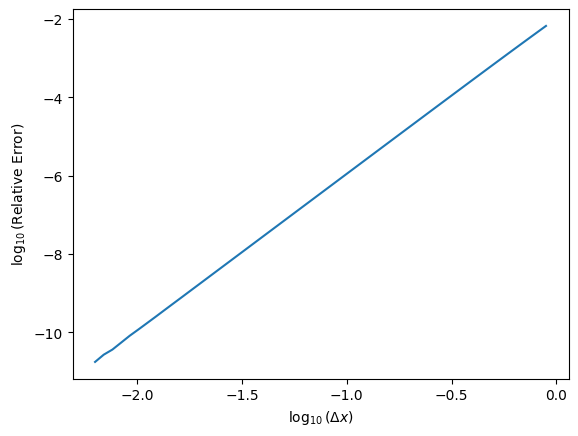

In [10]:
# Step 2.b: Plot log10(E_rel) versus log10(Delta_x)
import numpy as np
import matplotlib.pyplot as plt

x, y = np.loadtxt(os.path.join(Ccodesrootdir, "data.txt"), delimiter="\t", unpack=True)
fig, ax = plt.subplots()
ax.set_xlabel(r"$\log_{10}(\Delta x)$")
ax.set_ylabel(r"$\log_{10}(\text{Relative Error})$")
ax.plot(x, y)
plt.show()

A quick glance at the above plot indicates that between $\log_{10}(\Delta x) \approx -2.0$ and $\log_{10}(\Delta x) \approx -1.0$, the logarithmic relative error $\log_{10} E_{\rm Rel}$ increases by about $4$, indicating a positive slope of approximately $4$. Thus we have confirmed fourth-order convergence.

# Step 3: Exercises
### [Back to [top](#Table-of-Contents)]

1. Use NumPy's [`polyfit()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) function to evaluate the least-squares slope of the above line.
2. Explore $\log_{10}(\Delta x)$ outside the above (truncation-error-dominated) range. What other errors dominate outside the truncation-error-dominated regime?
3. Adjust the above NRPy and C codes to support sixth-order-accurate finite differencing. What should the slope of the resulting plot of $\log_{10} E_{\rm Rel}$ versus $\log_{10}(\Delta x)$ be? Explain why this case does not provide as clean a slope as the fourth-order case.